In [3]:
!pip install segmentation-models-pytorch

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=fd73bf595bac43bc5eecf180f7ea9c108ef88372caf6b41f702e479ff06a7a39
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0fbc70d6b4c07626a842d5f34e90f5915b105811158e3a2a98e10ce0327ccccf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [23]:
!pip install torchsummary

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [24]:
import segmentation_models_pytorch
import torchvision
import pandas as pd
import cv2
import numpy as np


import torch
from torchsummary import summary
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

In [5]:
PATH__DATA = r'/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/'
PATH__FILES = r'/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/'
PATH__MASKS = r'/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/'

df = pd.read_csv(PATH__DATA + r'list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [6]:
import os

df['mask'] = df['mask'].apply(lambda x: x if os.path.exists(PATH__MASKS + x) else None)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   width     28594 non-null  int64 
 2   height    28594 non-null  int64 
 3   class     28594 non-null  object
 4   xmin      28594 non-null  int64 
 5   ymin      28594 non-null  int64 
 6   xmax      28594 non-null  int64 
 7   ymax      28594 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [8]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df = df[:2000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 2003
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   width     2000 non-null   int64 
 2   height    2000 non-null   int64 
 3   class     2000 non-null   object
 4   xmin      2000 non-null   int64 
 5   ymin      2000 non-null   int64 
 6   xmax      2000 non-null   int64 
 7   ymax      2000 non-null   int64 
 8   mask      2000 non-null   object
dtypes: int64(6), object(3)
memory usage: 156.2+ KB


In [9]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00020165.jpg,1280,720,Lips,594,191,665,246,mask00020165.png
1,image00015353.jpg,1280,720,Lips,633,379,732,430,mask00015353.png
2,image00014919.jpg,1280,720,Lips,580,249,644,288,mask00014919.png
3,image00020903.jpg,1280,720,Lips,735,44,859,117,mask00020903.png
4,image00027862.jpg,1280,720,Lips,680,363,847,452,mask00027862.png


In [44]:
class DatasetLips(Dataset):
    def __init__(self, df, preprocessing=None):
        self.df = df
        self.images = df['filename']
        self.masks = df['mask']
        self.preprocessing = preprocessing
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(PATH__FILES + self.images[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0
        
        img = img.permute(2, 0, 1)
        
        mask = cv2.cvtColor(cv2.imread(PATH__MASKS + self.masks[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256))
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.permute(2, 0, 1)
        mask = mask[1, :, :]
        
        return (img.float(), mask)
    
    def __len__(self):
        return len(self.df)

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [39]:
import segmentation_models_pytorch as smp 


BACKBONE = 'resnet34'
segmodel = smp.PSPNet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [41]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [50]:
summary(segmodel.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

torch.Size([3, 256, 256]) torch.Size([256, 256])


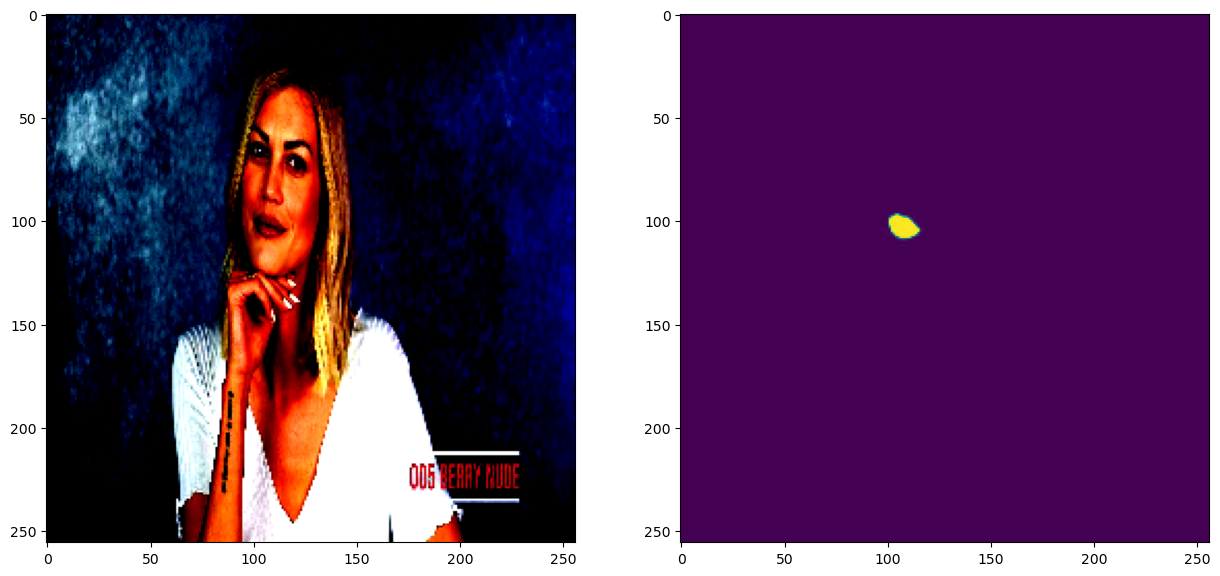

In [46]:
dataset = DatasetLips(df, preprocessing=preprocess_input)
img, masks = dataset[55]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(0, 1))
plt.show()

In [27]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=11)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

data_train = DatasetLips(X_train)
data_test = DatasetLips(X_test)

In [28]:
train_data_loader = DataLoader(
    data_train,
    batch_size=64,
    shuffle=True
)
test_data_loader = DataLoader(
    data_test,
    batch_size=32,
    shuffle=False
)

In [29]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [30]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [47]:
num_epochs = 1

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s, dice_loss - -2.236, iou_score - -2.708]


In [48]:
# Загрузка модели.
model = torch.load('./best_model.pth').to('cpu')

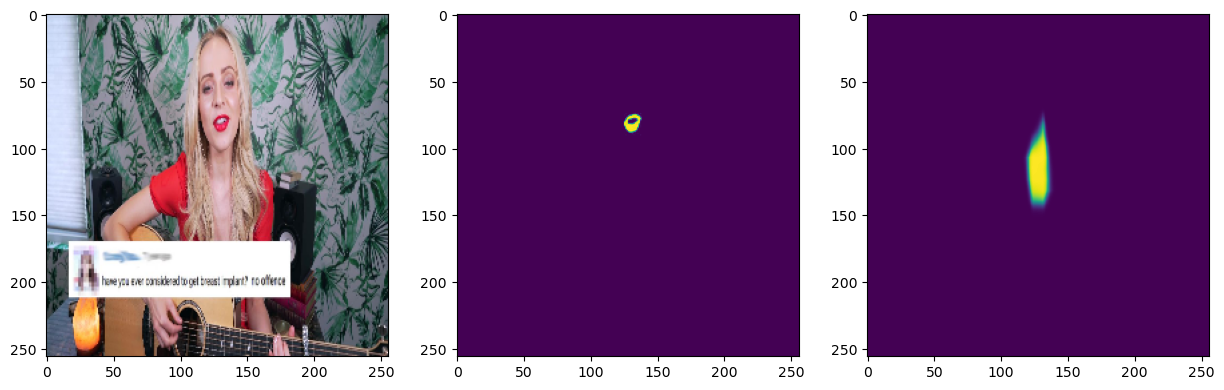

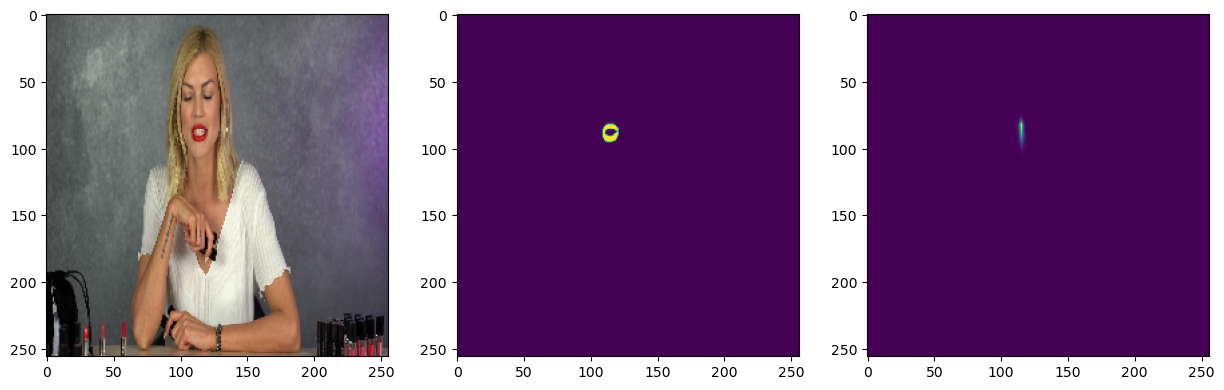

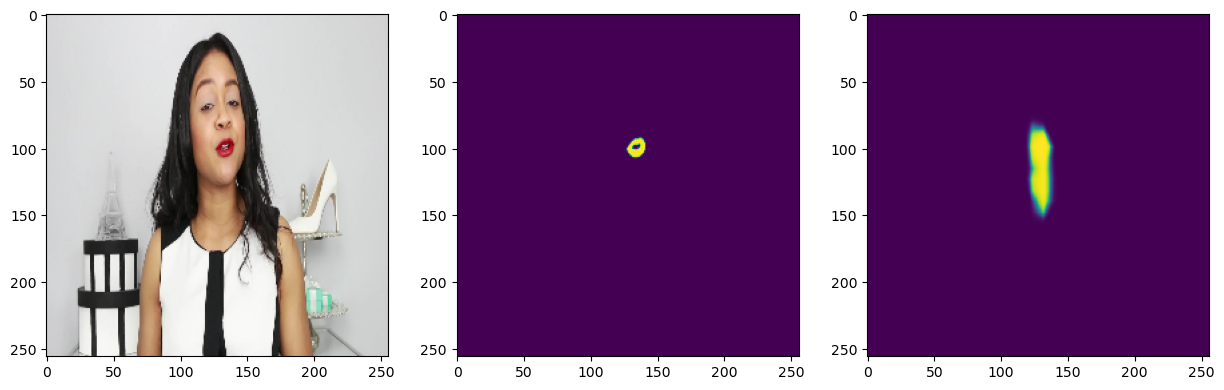

In [49]:
i = 0

for img, target in test_data_loader:
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0])
    
    output = model.predict(img)
    ax[2].imshow(output[0].permute(1, 2, 0))
    
    i += 1
    
    if i == 3:
        break